# ISPR Midterm 2 - Assignment 3
## Diego Arcelli - 647979
### Training a Restricted Boltzman Machine on MNIST dataset

## Importing needed modules

In [ ]:
!pip install idx2numpy
import numpy as np
import gzip
import matplotlib.pyplot as plt
import idx2numpy
from tqdm import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Dowloading the dataset

In [ ]:
!wget http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz

sources = [
    't10k-images-idx3-ubyte.gz',
    't10k-labels-idx1-ubyte.gz',
    'train-images-idx3-ubyte.gz',
    'train-labels-idx1-ubyte.gz'
]

targets = [
    't10k-images.idx3-ubyte',
    't10k-labels.idx1-ubyte',
    'train-images.idx3-ubyte',
    'train-labels.idx1-ubyte'
]

for src, trg in zip(sources, targets):
  with gzip.open(src, 'rb') as f:
    file_content = f.read()
    with open(trg, "wb") as f_out:
      f_out.write(file_content)

!rm train-images-idx3-ubyte.gz
!rm train-labels-idx1-ubyte.gz
!rm t10k-images-idx3-ubyte.gz
!rm t10k-labels-idx1-ubyte.gz

--2023-04-01 13:54:10--  http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 172.67.171.76, 104.21.29.36, 2606:4700:3034::6815:1d24, ...
Connecting to yann.lecun.com (yann.lecun.com)|172.67.171.76|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/x-gzip]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]   9.45M  --.-KB/s    in 0.1s    

2023-04-01 13:54:10 (94.7 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [9912422/9912422]

--2023-04-01 13:54:10--  http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 172.67.171.76, 104.21.29.36, 2606:4700:3034::6815:1d24, ...
Connecting to yann.lecun.com (yann.lecun.com)|172.67.171.76|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28881 (28K) [application/x-gzip]
Saving to: ‘train-labels-idx1-ubyte.gz’

train-labels-idx1-u 100%[=========

## Defining some utility functions
These are the functions which are used to present the result

In [ ]:
# computes the sigmoid function
def sigmoid(x):
  return 1/(1+np.e**(-x))
  
'''
function used to plot in a grid some images of the MNIST dataset
'''
def visualize_image_grid(images, labels, size=5):
  n = size*size
  fig, ax = plt.subplots(size, size, figsize=(15, 15))

  idx = 0

  for i in range(size):
    for j in range(size):
      ax[i,j].imshow(images[idx], cmap='Greys')
      ax[i,j].set_xticks([])
      ax[i,j].set_yticks([])
      ax[i,j].set_title(f"Label: {labels[idx]}")

      idx += 1
      

'''
function used to load the data and return train-test images and labels
'''
def read_data(train_data_path='train-images.idx3-ubyte',
              train_label_path='train-labels.idx1-ubyte',
              test_data_path='t10k-images.idx3-ubyte',
              test_label_path='t10k-labels.idx1-ubyte'
              ):
  train_data = idx2numpy.convert_from_file(train_data_path)
  train_label = idx2numpy.convert_from_file(train_label_path)
  test_data = idx2numpy.convert_from_file(test_data_path)
  test_label = idx2numpy.convert_from_file(test_label_path)

  return train_data, train_label, test_data, test_label


'''
function that returns the indices of the first k of
occurrences of the passed digit in the label tensor 
'''
def get_first_k_images(label, digit, k):
  return np.argwhere(label == digit)[:k]

'''
function to compute the MSE given the original
image and the reconstructed version
'''
def compute_mse(org, rec):
  org = org.reshape(784)
  rec = rec.reshape(784)
  mse = ((org-rec)**2).sum()
  return mse

'''
function to plot as images the weights of
the weights matrix of the boltzman machine
'''
def plot_weights(M, n_cols = 5, figsize=(15, 15)):

  v_dim, h_dim = M.shape

  img_size = int(np.sqrt(v_dim))
  n_rows = h_dim // n_cols

  n_rows = n_rows  if h_dim % n_cols == 0 else n_rows + 1


  fig, ax = plt.subplots(n_rows, n_cols, figsize=figsize)

  idx = 0
  for i in range(n_rows):
    for j in range(n_cols):

      if idx >= h_dim:
        ax[i,j].set_axis_off()
        continue

      ax[i,j].imshow(M[:, idx].reshape(img_size, img_size), cmap='Greys')
      ax[i,j].set_xticks([])
      ax[i,j].set_yticks([])

      idx+=1

  plt.show()
      

'''
function to plot the original image, the image reconstructed by the
RBM and the hidden representation of the image produced by the RBM
'''
def plot_result(org, rec, hid, label=None):

  mse = compute_mse(org, rec)

  fig, ax = plt.subplots(1, 3, figsize=(12, 6))

  if label != None:
    fig.suptitle(f"Label: {label}\nMSE: {round(mse, 5)}", fontsize=15)

  fig.subplots_adjust(top=1.1)

  ax[0].imshow(org, cmap='Greys')
  ax[1].imshow(rec, cmap='Greys')
  ax[2].imshow(hid, cmap='Greys')

  ax[0].set_title("Original")
  ax[1].set_title("Reconstructed")
  ax[2].set_title("Hidden representation")

  ax[0].set_xticks([])
  ax[0].set_yticks([])
  ax[1].set_xticks([])
  ax[1].set_yticks([])
  ax[2].set_xticks([])
  ax[2].set_yticks([])

  plt.show()


'''
function to plot the results of the reconstruction
of the RBM for a specific digit
'''
def plot_images(model, data, label, digit, k):
  size = int(np.sqrt(model.n_hidden))
  for idx in get_first_k_images(label, digit, k):
      v_a, v_p, h_a, h_p = model.reconstruct(data[idx.item()].reshape(1, -1))
      plot_result(test_data[idx.item()], v_p.reshape(28, 28), h_p.reshape(size, size), label[idx.item()])
      print("\n\n\n")

'''
function that compute the MSE of a batch of images
'''
def compute_batch_mse(model, data):
  n = data.shape[0]
  data = data.reshape(n, 784)
  pred, _, _, _ = model.reconstruct(data)
  mse = (((data-pred)**2).sum())/n
  return mse

## Loading the dataset
We load the train and the test set and we rescale the datasets dividing them by 255, so that each pixel varies beteween 0 and 1

In [ ]:
train_data, train_label, test_data, test_label = read_data()

train_data = train_data/255
test_data = test_data/255

print(train_data.shape, train_label.shape)
print(test_data.shape, test_label.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


## Visualize images of the dataset

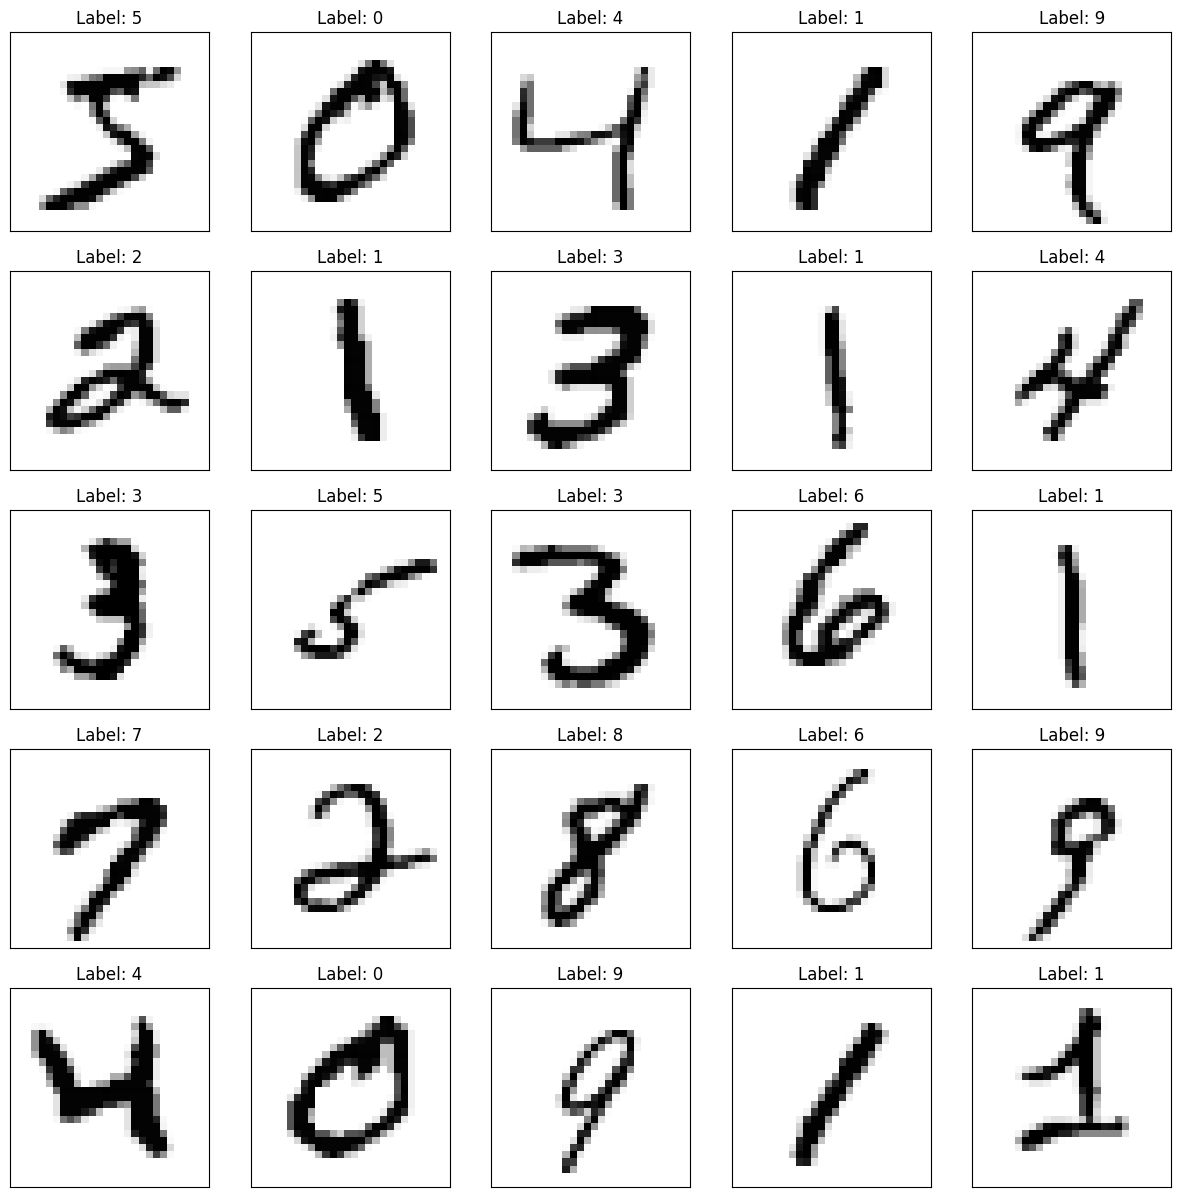

In [ ]:
size = 5
visualize_image_grid(train_data[:size*size], train_label[:size*size], 5)

## Defining the class representing the RBM

In [ ]:
class RBM:

  def __init__(self, n_visible, n_hidden):
    # number of the hidden units
    self.n_hidden = n_hidden
    # number of the visible units
    self.n_visible = n_visible
    # initialization of the weights matrix
    self.M = np.random.randn(n_visible, n_hidden)
    # initialization of the bias vector for the visible units
    self.b = np.random.randn(n_visible)
    # initialization of the bias vector for the hidden units
    self.c = np.random.randn(n_hidden)

  '''
  function that computes the probabilities and the activations
  of the visible units given the activation of the hidden units
  '''
  def visible_forward(self, h):
    potential = np.matmul(h, self.M.T) + self.b
    probs = sigmoid(potential)
    mask = np.random.uniform(0, 1, probs.shape)
    activations = (probs > mask).astype(np.uint8)
    return activations, probs

  '''
  function that computes the probabilities and the activations
  of the hidden units given the activation of the visible units
  '''
  def hidden_forward(self, v):
    potential = np.matmul(v, self.M) + self.c
    probs = sigmoid(potential)
    mask = np.random.uniform(0, 1, probs.shape)
    activations = (probs > mask).astype(np.uint8)
    return activations, probs

  '''
  function that receives the activations of the visible units, produces the hidden 
  units activations and uses them to re-create the visible units activations
  '''
  def reconstruct(self, v):
    h_a, h_p = self.hidden_forward(v)
    v_a, v_p = self.visible_forward(h_a)
    return v_a, v_p, h_a, h_p


  '''
  function that implements the training loop of the model
  '''
  def train(self, train_data, epochs=50, batch_size=32, lr=1):

    n = train_data.shape[0]
    iters = n // batch_size
    iters = iters if (n % batch_size == 0) else iters + 1

    train_data = train_data.reshape(n, -1)

    # the data are divided in batches according to the batch size
    batch_data = [train_data[i*batch_size:(i+1)*batch_size, :] for i in range(iters)]
    
    # we iterate the training for a certain number of epochs
    for epoch in range(epochs):
      print(f"Training epoch {epoch+1}/{epochs}")

      total_err = 0

      # we update the model parameters for each batch of data
      with tqdm(total=iters) as pbar:
        for batch in batch_data:
          
          N = batch.shape[0]

          # we do the training using CD-1
          v_0 = batch
          h_0_a, h_0_p = model.hidden_forward(v_0)
          v_1_a, v_1_p = model.visible_forward(h_0_a)
          h_1_a, h_1_p = model.hidden_forward(v_1_a)
          
          wake = np.einsum('ki,kj->kij', v_0, h_0_p)
          dream = np.einsum('ki,kj->kij', v_1_a, h_1_p)

          # computing the reconstruction error using the MSE
          err = (((v_1_a-v_0)**2).sum())/N
          total_err += err

          delta_M = ((wake-dream).sum(axis=0))/N
          delta_b = ((v_0-v_1_a).sum(axis=0))/N
          delta_c = ((h_0_p-h_1_p).sum(axis=0))/N


          # updating of the model parameters
          self.M += delta_M*lr
          self.b += delta_b*lr
          self.c += delta_c*lr

          pbar.update(1)

      print(f"MSE epoch {epoch+1}: {total_err/iters}\n")

## Training the model
The number of visible units of the RBM must be 784, since MNIST dataset is composed of 28$\times$28 images. The number of hidden units has been set to 64.

In [ ]:
model = RBM(784, 64)
model.train(train_data, epochs=50, batch_size=32, lr=0.75)

Training epoch 1/50


100%|██████████| 1875/1875 [00:52<00:00, 35.92it/s]


MSE epoch 1: 79.69058626861468

Training epoch 2/50


100%|██████████| 1875/1875 [00:46<00:00, 39.97it/s]


MSE epoch 2: 72.39164149737272

Training epoch 3/50


100%|██████████| 1875/1875 [00:44<00:00, 41.92it/s]


MSE epoch 3: 70.99095561501976

Training epoch 4/50


100%|██████████| 1875/1875 [00:46<00:00, 40.68it/s]


MSE epoch 4: 70.20884110521594

Training epoch 5/50


100%|██████████| 1875/1875 [00:44<00:00, 42.33it/s]


MSE epoch 5: 69.1111214973729

Training epoch 6/50


100%|██████████| 1875/1875 [00:45<00:00, 41.01it/s]


MSE epoch 6: 67.81891901371266

Training epoch 7/50


100%|██████████| 1875/1875 [00:45<00:00, 40.87it/s]


MSE epoch 7: 66.08670411175184

Training epoch 8/50


100%|██████████| 1875/1875 [00:45<00:00, 41.09it/s]


MSE epoch 8: 64.66536548430086

Training epoch 9/50


100%|██████████| 1875/1875 [00:45<00:00, 41.27it/s]


MSE epoch 9: 63.278337837242056

Training epoch 10/50


100%|██████████| 1875/1875 [00:45<00:00, 41.36it/s]


MSE epoch 10: 62.6704741117519

Training epoch 11/50


100%|██████████| 1875/1875 [00:42<00:00, 44.13it/s]


MSE epoch 11: 62.01175110521584

Training epoch 12/50


100%|██████████| 1875/1875 [00:45<00:00, 41.42it/s]


MSE epoch 12: 61.390304569268416

Training epoch 13/50


100%|██████████| 1875/1875 [00:43<00:00, 43.47it/s]


MSE epoch 13: 60.998057967960904

Training epoch 14/50


100%|██████████| 1875/1875 [00:44<00:00, 42.29it/s]


MSE epoch 14: 60.67568208560802

Training epoch 15/50


100%|██████████| 1875/1875 [00:43<00:00, 43.15it/s]


MSE epoch 15: 60.29567528822252

Training epoch 16/50


100%|██████████| 1875/1875 [00:44<00:00, 42.41it/s]


MSE epoch 16: 60.07868358887619

Training epoch 17/50


100%|██████████| 1875/1875 [00:45<00:00, 41.30it/s]


MSE epoch 17: 59.91651398103287

Training epoch 18/50


100%|██████████| 1875/1875 [00:43<00:00, 42.74it/s]


MSE epoch 18: 59.71206437318976

Training epoch 19/50


100%|██████████| 1875/1875 [00:44<00:00, 42.35it/s]


MSE epoch 19: 59.62375554966045

Training epoch 20/50


100%|██████████| 1875/1875 [00:44<00:00, 42.41it/s]


MSE epoch 20: 59.436804896065695

Training epoch 21/50


100%|██████████| 1875/1875 [00:43<00:00, 42.75it/s]


MSE epoch 21: 59.12214489606562

Training epoch 22/50


100%|██████████| 1875/1875 [00:45<00:00, 41.37it/s]


MSE epoch 22: 58.552388033320426

Training epoch 23/50


100%|██████████| 1875/1875 [00:43<00:00, 43.08it/s]


MSE epoch 23: 58.382119536588505

Training epoch 24/50


100%|██████████| 1875/1875 [00:44<00:00, 42.02it/s]


MSE epoch 24: 58.172019732666826

Training epoch 25/50


100%|██████████| 1875/1875 [00:44<00:00, 42.41it/s]


MSE epoch 25: 57.93137685684991

Training epoch 26/50


100%|██████████| 1875/1875 [00:43<00:00, 43.38it/s]


MSE epoch 26: 57.970682739202836

Training epoch 27/50


100%|██████████| 1875/1875 [00:45<00:00, 41.22it/s]


MSE epoch 27: 57.82960417711142

Training epoch 28/50


100%|██████████| 1875/1875 [00:44<00:00, 42.49it/s]


MSE epoch 28: 57.759975484300845

Training epoch 29/50


100%|██████████| 1875/1875 [00:43<00:00, 42.75it/s]


MSE epoch 29: 57.75065385031393

Training epoch 30/50


100%|██████████| 1875/1875 [00:44<00:00, 42.23it/s]


MSE epoch 30: 57.632688229398894

Training epoch 31/50


100%|██████████| 1875/1875 [00:43<00:00, 42.73it/s]


MSE epoch 31: 57.297956530052566

Training epoch 32/50


100%|██████████| 1875/1875 [00:44<00:00, 42.34it/s]


MSE epoch 32: 57.10347149737282

Training epoch 33/50


100%|██████████| 1875/1875 [00:45<00:00, 41.08it/s]


MSE epoch 33: 56.92015809868009

Training epoch 34/50


100%|██████████| 1875/1875 [00:43<00:00, 43.03it/s]


MSE epoch 34: 56.77490764116359

Training epoch 35/50


100%|██████████| 1875/1875 [00:44<00:00, 42.22it/s]


MSE epoch 35: 56.5884469222094

Training epoch 36/50


100%|██████████| 1875/1875 [00:44<00:00, 42.11it/s]


MSE epoch 36: 56.46525032090227

Training epoch 37/50


100%|██████████| 1875/1875 [00:43<00:00, 42.85it/s]


MSE epoch 37: 56.353586072536224

Training epoch 38/50


100%|██████████| 1875/1875 [00:45<00:00, 41.11it/s]


MSE epoch 38: 56.240863196719104

Training epoch 39/50


100%|██████████| 1875/1875 [00:43<00:00, 42.89it/s]


MSE epoch 39: 56.24759934051007

Training epoch 40/50


100%|██████████| 1875/1875 [00:44<00:00, 42.22it/s]


MSE epoch 40: 56.144286726131014

Training epoch 41/50


100%|██████████| 1875/1875 [00:44<00:00, 42.33it/s]


MSE epoch 41: 56.132163915673445

Training epoch 42/50


100%|██████████| 1875/1875 [00:43<00:00, 42.74it/s]


MSE epoch 42: 56.03405404639235

Training epoch 43/50


100%|██████████| 1875/1875 [00:45<00:00, 41.23it/s]


MSE epoch 43: 55.95713215096755

Training epoch 44/50


100%|██████████| 1875/1875 [00:43<00:00, 42.89it/s]


MSE epoch 44: 55.7996610398565

Training epoch 45/50


100%|██████████| 1875/1875 [00:44<00:00, 42.34it/s]


MSE epoch 45: 55.82253293528132

Training epoch 46/50


100%|██████████| 1875/1875 [00:44<00:00, 41.86it/s]


MSE epoch 46: 55.819918229399

Training epoch 47/50


100%|██████████| 1875/1875 [00:44<00:00, 42.60it/s]


MSE epoch 47: 55.867722412405456

Training epoch 48/50


100%|██████████| 1875/1875 [00:44<00:00, 42.01it/s]


MSE epoch 48: 55.807762543124504

Training epoch 49/50


100%|██████████| 1875/1875 [00:45<00:00, 41.08it/s]


MSE epoch 49: 55.71858208560799

Training epoch 50/50


100%|██████████| 1875/1875 [00:43<00:00, 43.04it/s]

MSE epoch 50: 55.66155790260146



## Evaluate the model
We compute the MSE of the RBM on the training and test sets

In [ ]:
train_size = train_data.shape[0]
test_size = test_data.shape[0]

train_input = train_data.reshape(train_size, 784)
test_input = test_data.reshape(test_size, 784)

train_pred, _, _, _ = model.reconstruct(train_input)
test_pred, _, _, _ = model.reconstruct(test_input)

train_mse = (((train_pred-train_input)**2).sum())/train_size
test_mse = (((test_pred-test_input)**2).sum())/test_size

print(f"Train MSE: {train_mse}")
print(f"Test MSE: {test_mse}")

Train MSE: 56.04601607253601
Test MSE: 55.83225872510576


## Visualizing the weights of the model
The weight matrix is a 784$\times$64 matrix. We visualize each one of the 64 rows of the matrix as a 28$\times$28 image.

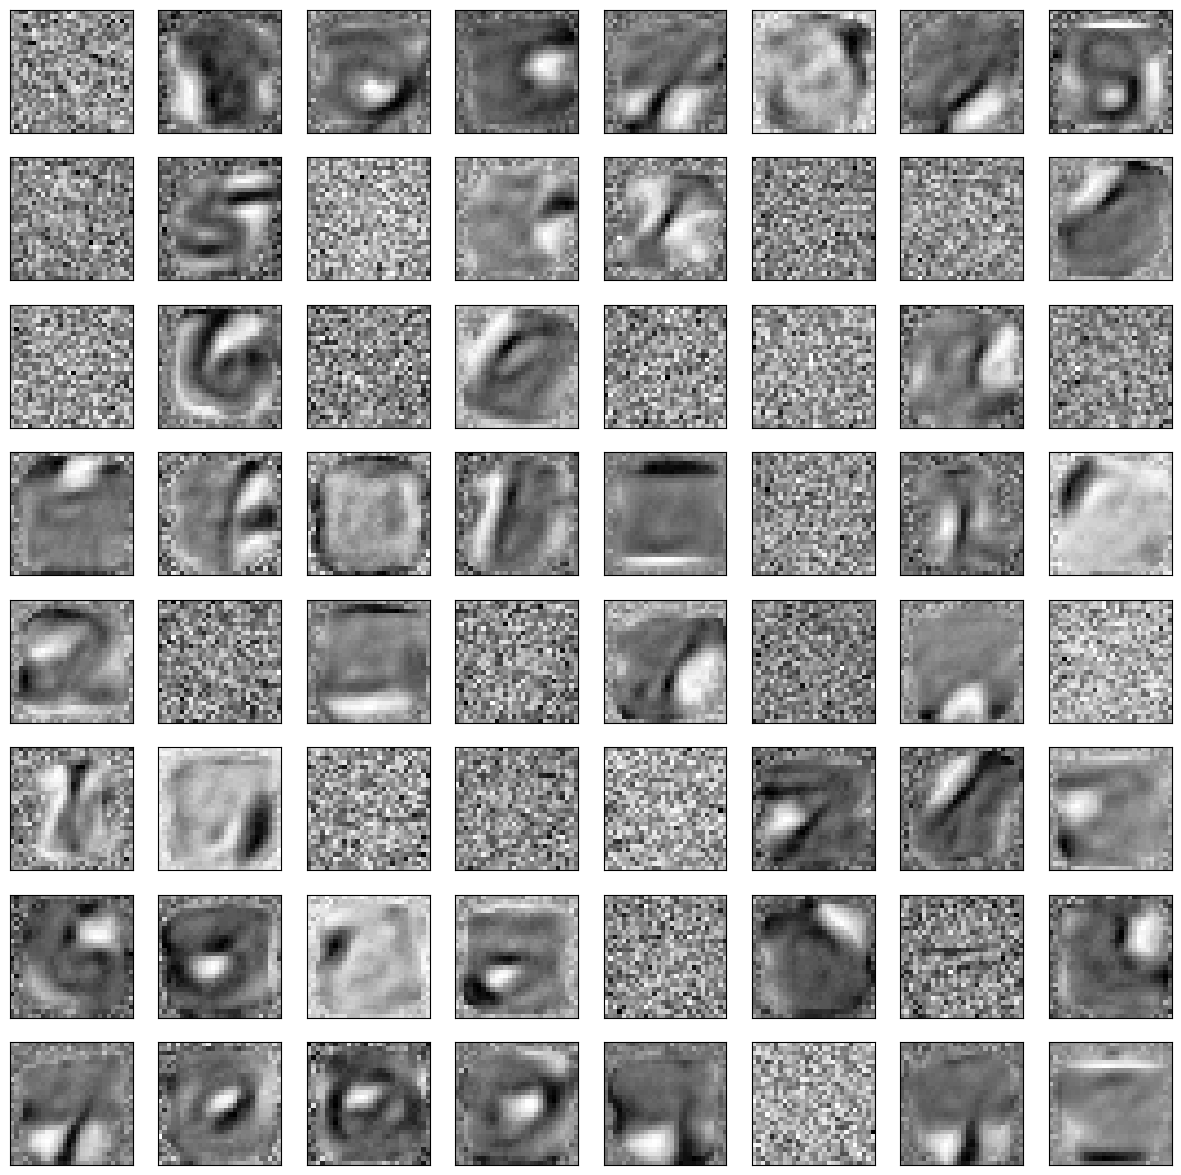

In [ ]:
plot_weights(model.M, n_cols=8, figsize=(15, 15))

## Visualize some example for each digit
For each digit we present five examples that show:
- The original image
- The image reconstructed by the RBM
- The RBM's hidden representation of the input image
- The MSE between the original and the reconstructed image

For each digit we also compute the average MSE on the test set images of that digit.

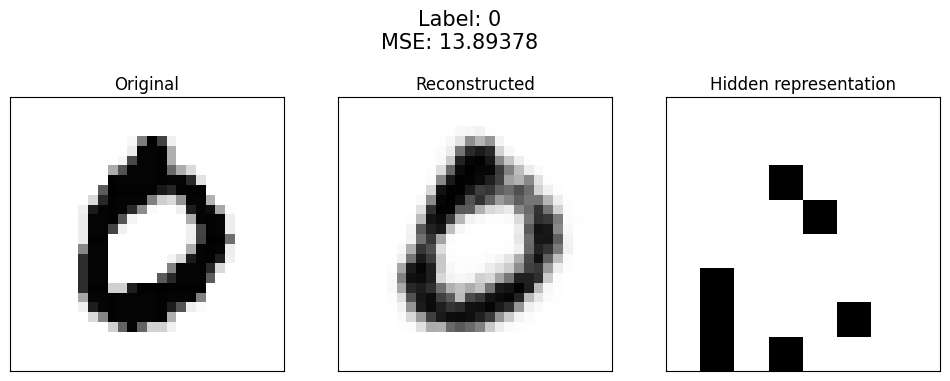

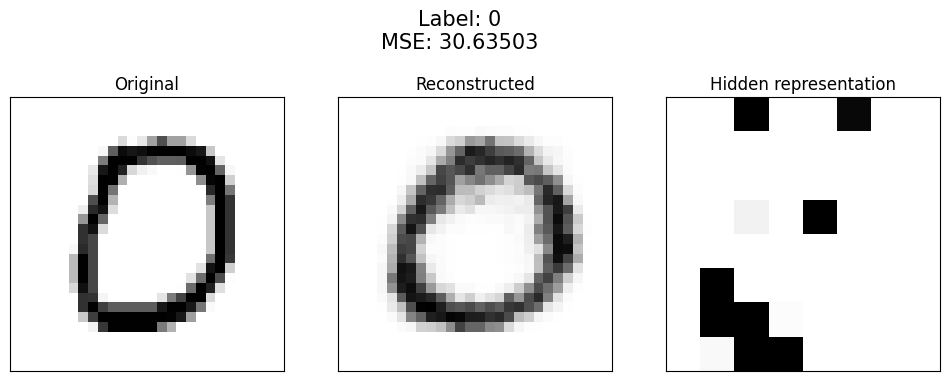

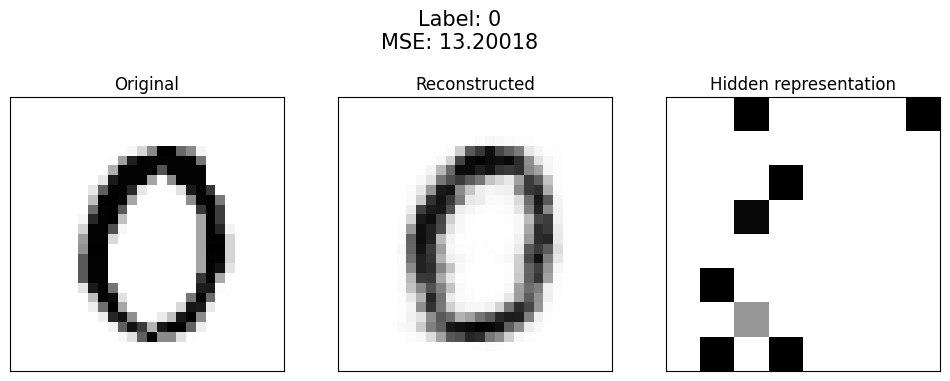

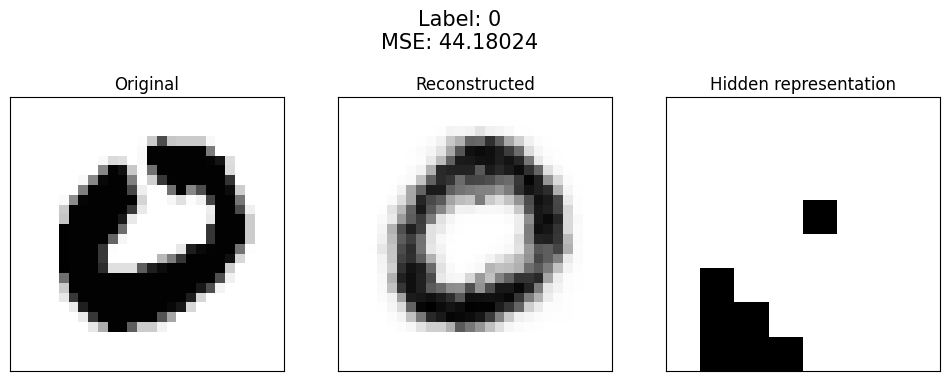

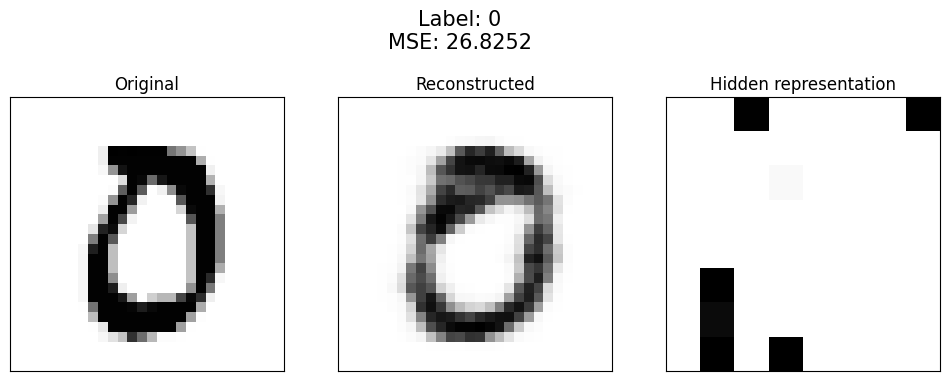





Digit 0 test MSE: 69.88603653226001


In [ ]:
k = 5
digit = 0
plot_images(model, test_data, test_label, digit, k)
mse = compute_batch_mse(model, test_data[test_label == digit])
print(f"Digit {digit} test MSE: {mse}")

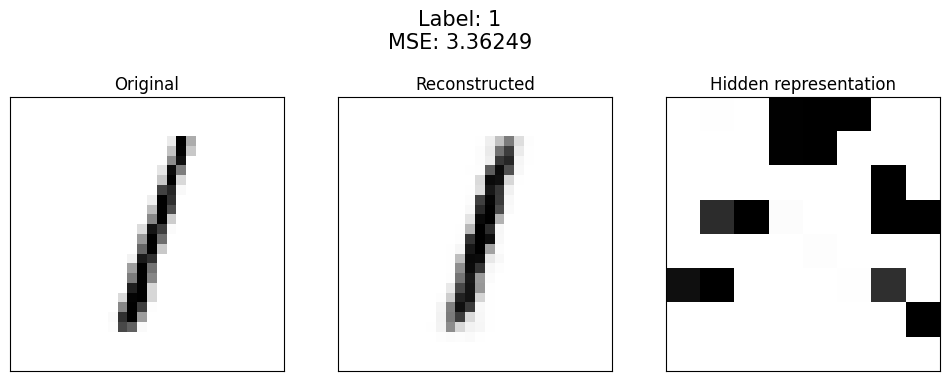

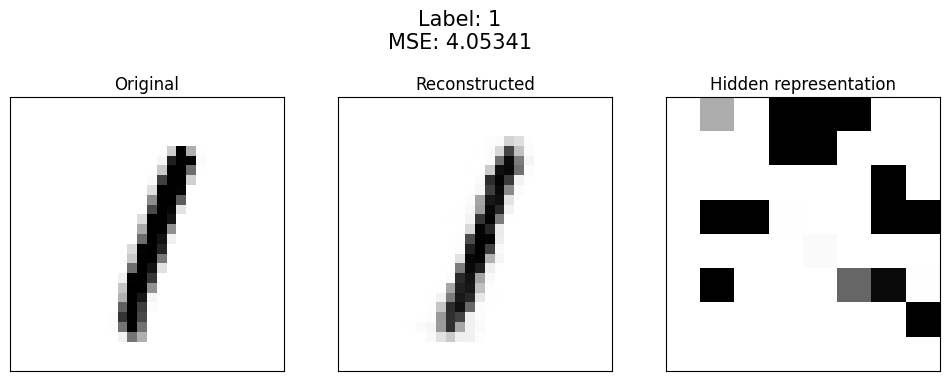

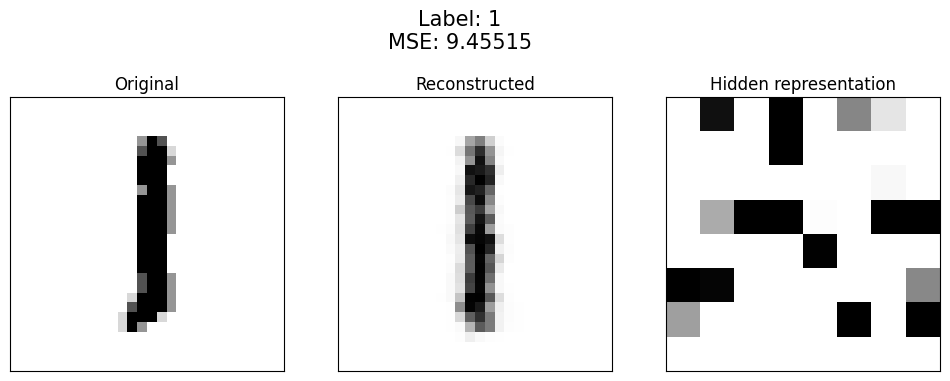

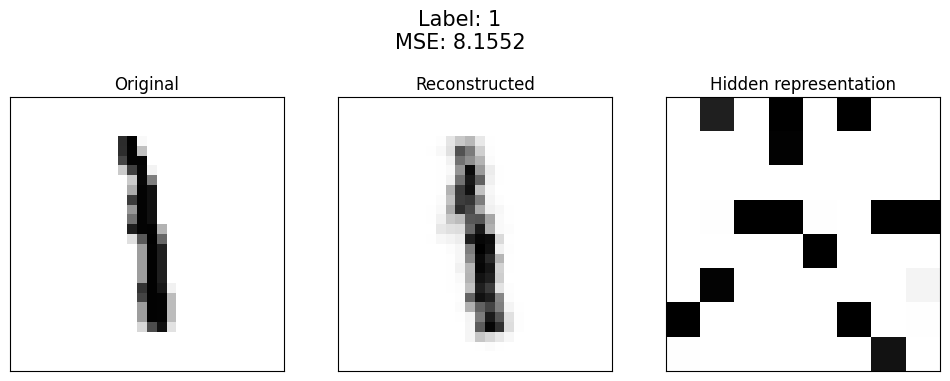

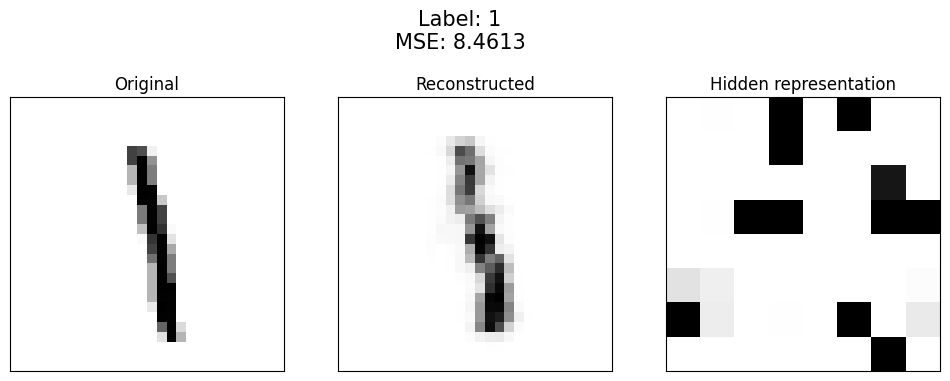





Digit 1 test MSE: 23.109800114154663


In [ ]:
digit = 1
plot_images(model, test_data, test_label, digit, k)
mse = compute_batch_mse(model, test_data[test_label == digit])
print(f"Digit {digit} test MSE: {mse}")

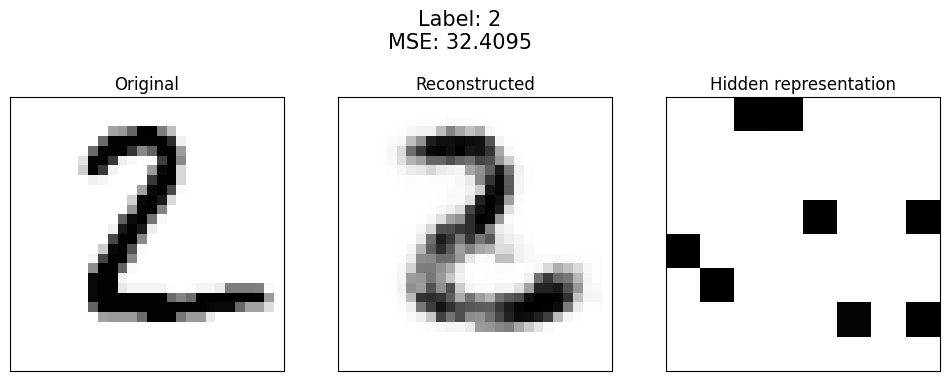

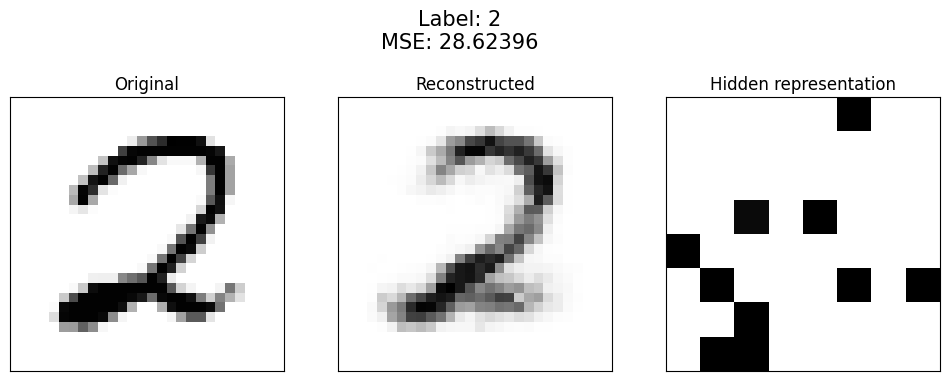

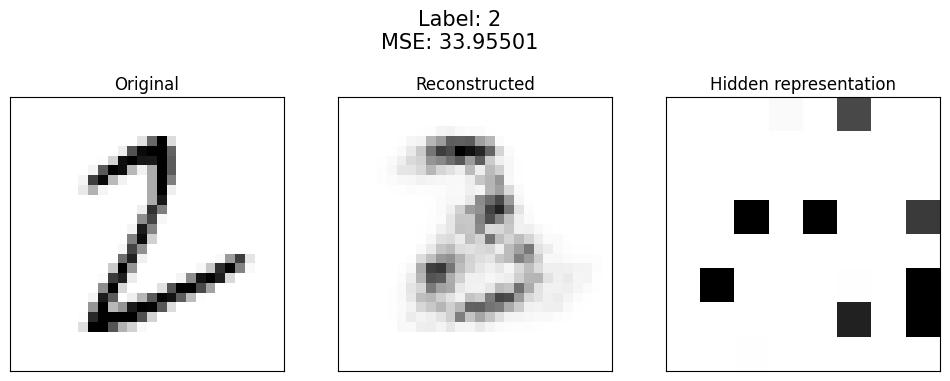

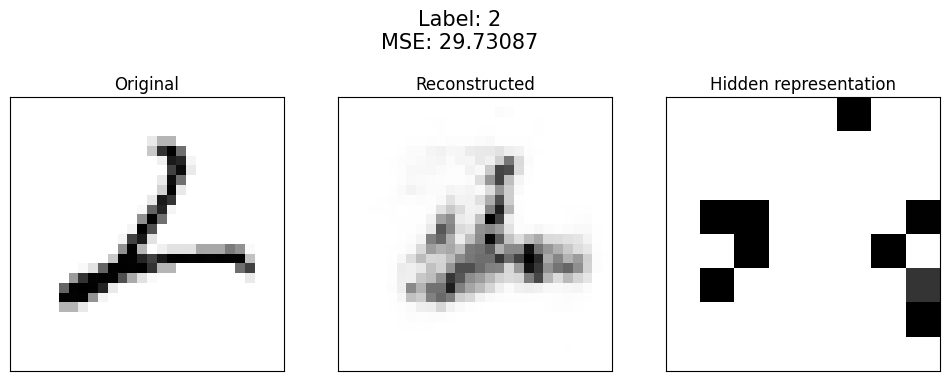

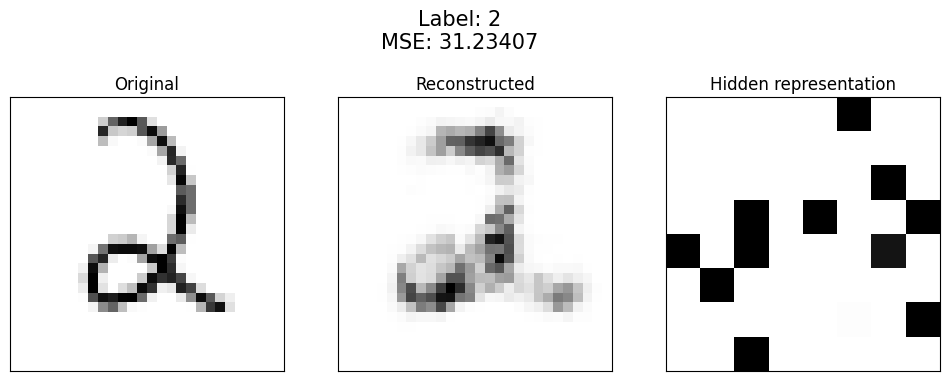





Digit 2 test MSE: 71.85514861606597


In [ ]:
digit = 2
plot_images(model, test_data, test_label, digit, k)
mse = compute_batch_mse(model, test_data[test_label == digit])
print(f"Digit {digit} test MSE: {mse}")

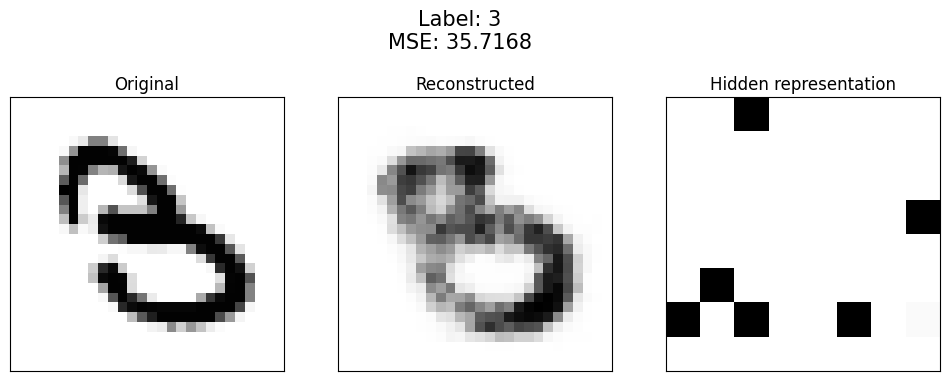

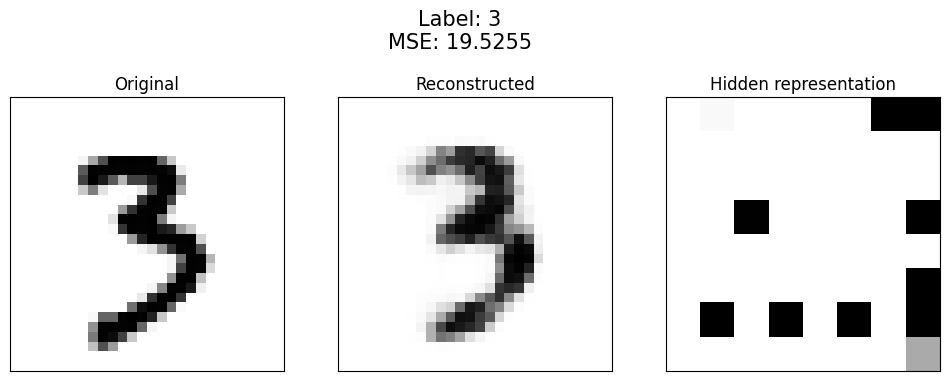

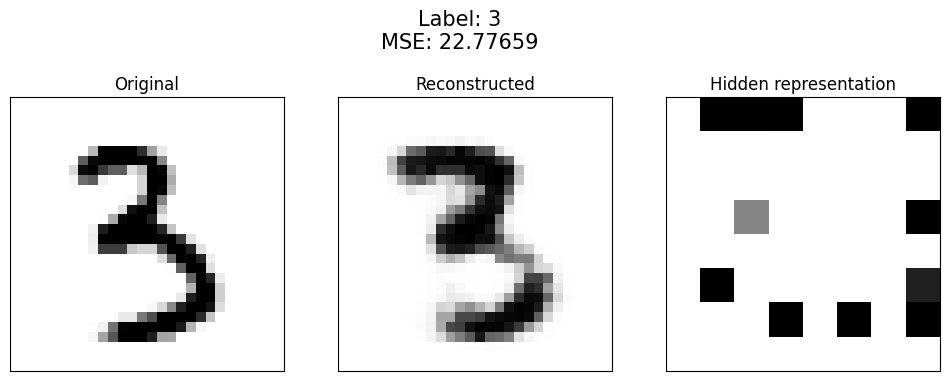

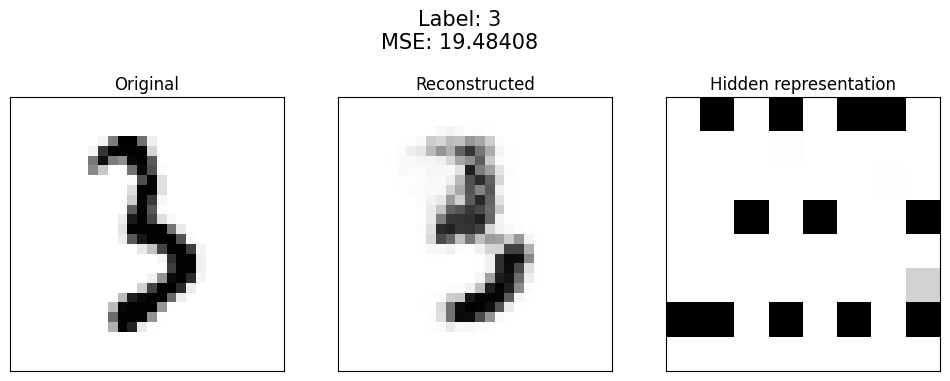

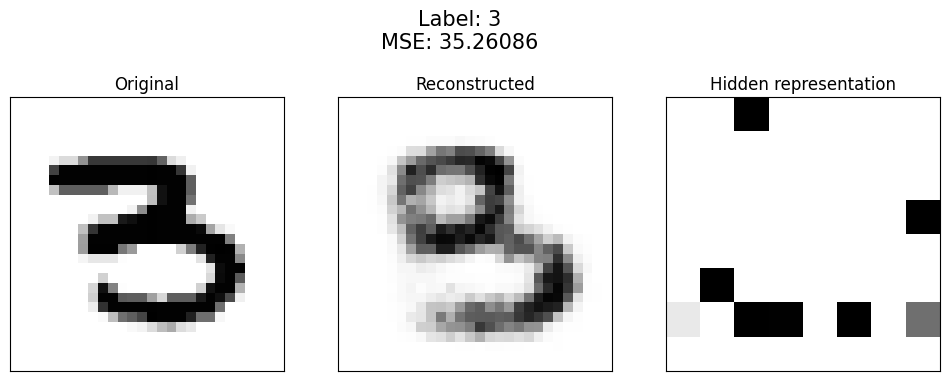





Digit 3 test MSE: 63.15234978169097


In [ ]:
digit = 3
plot_images(model, test_data, test_label, digit, k)
mse = compute_batch_mse(model, test_data[test_label == digit])
print(f"Digit {digit} test MSE: {mse}")

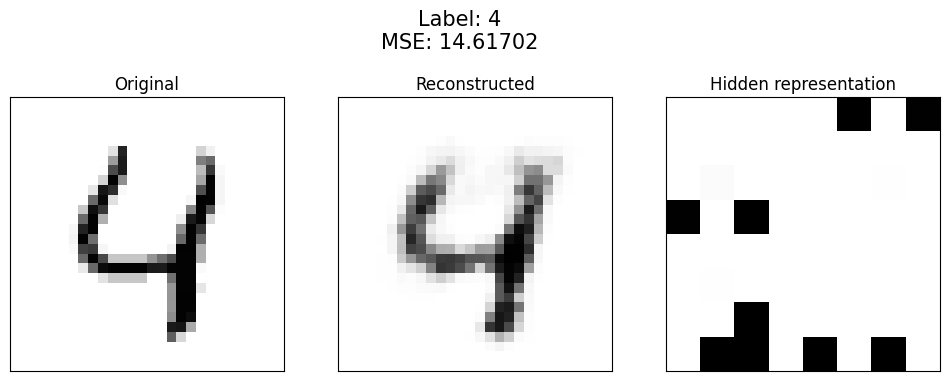

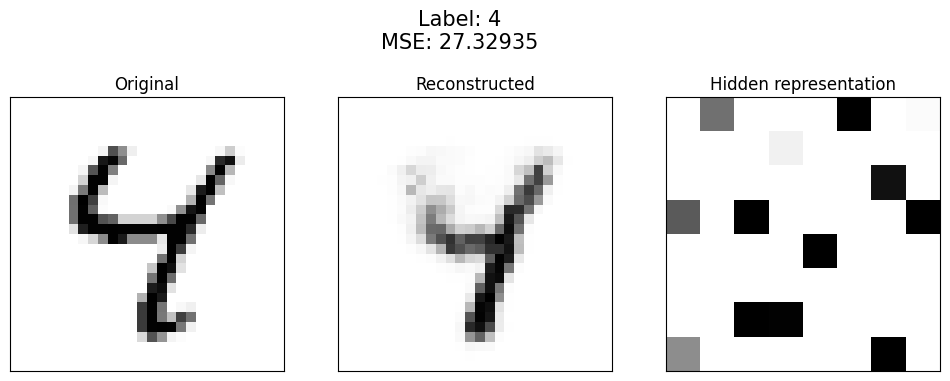

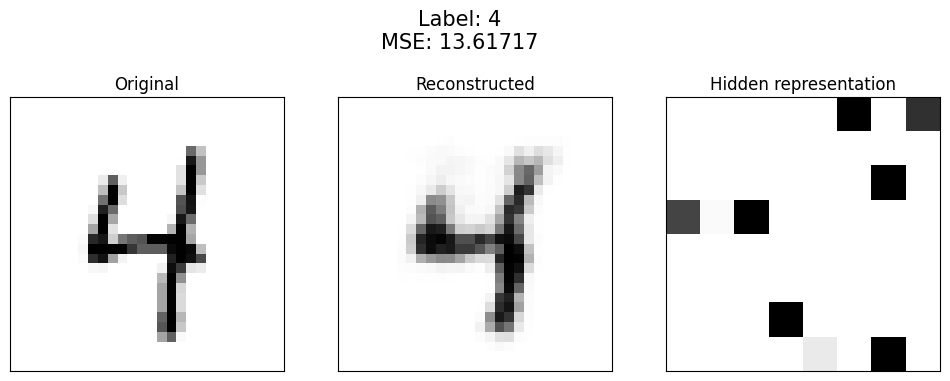

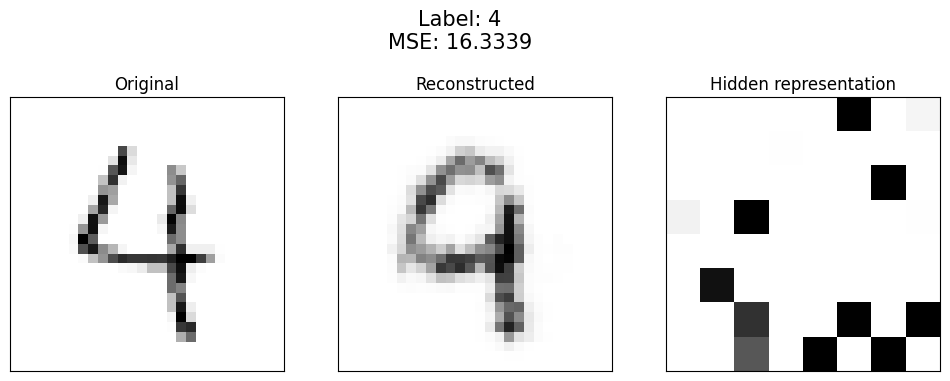

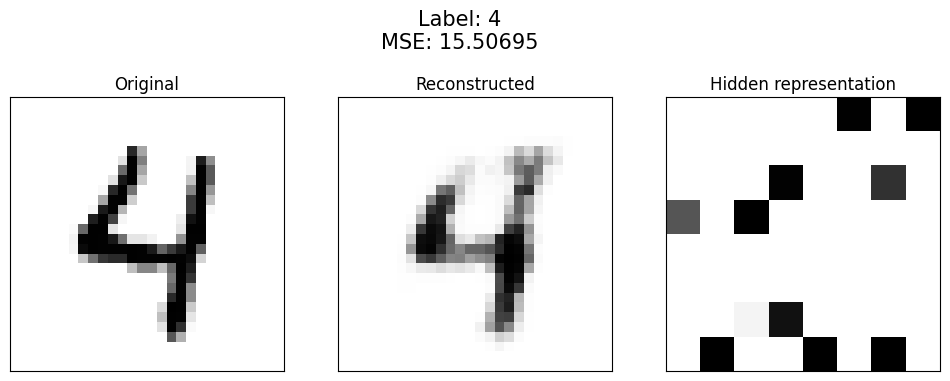





Digit 4 test MSE: 53.747840615899726


In [ ]:
digit = 4
plot_images(model, test_data, test_label, digit, k)
mse = compute_batch_mse(model, test_data[test_label == digit])
print(f"Digit {digit} test MSE: {mse}")

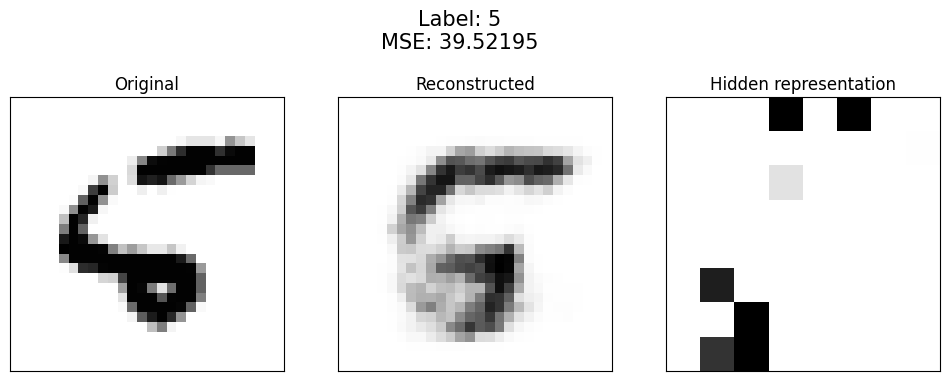

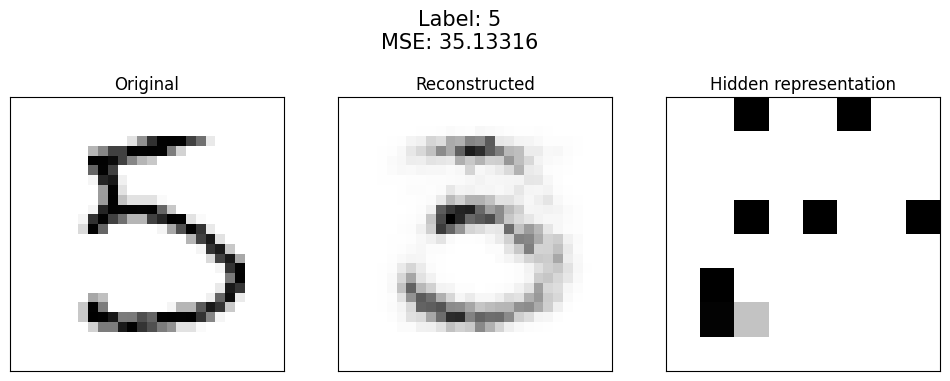

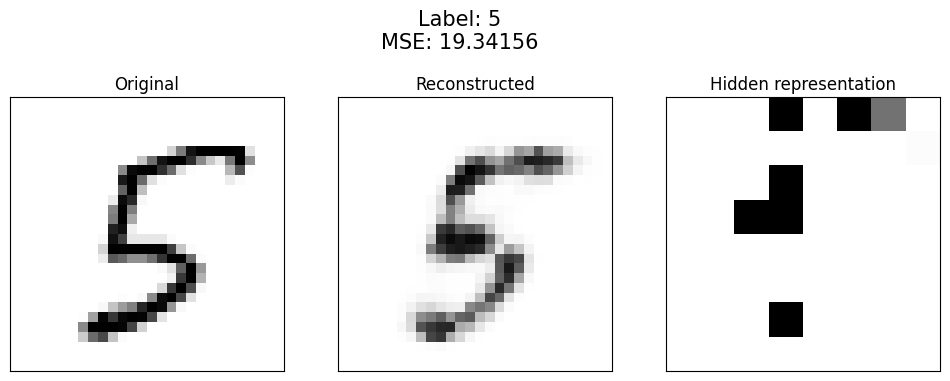

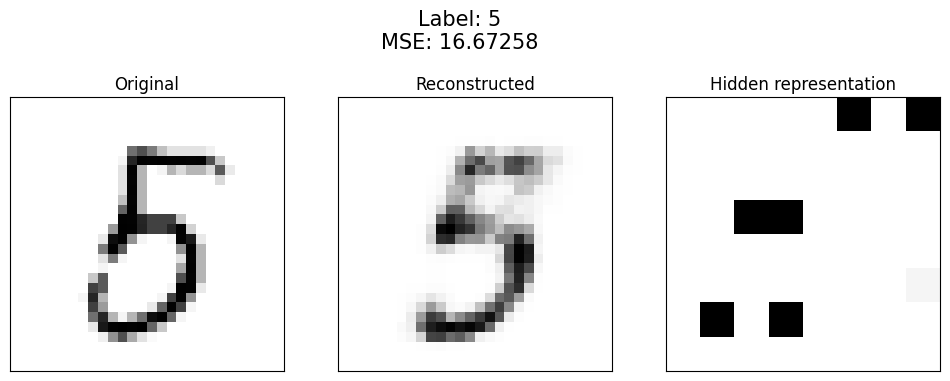

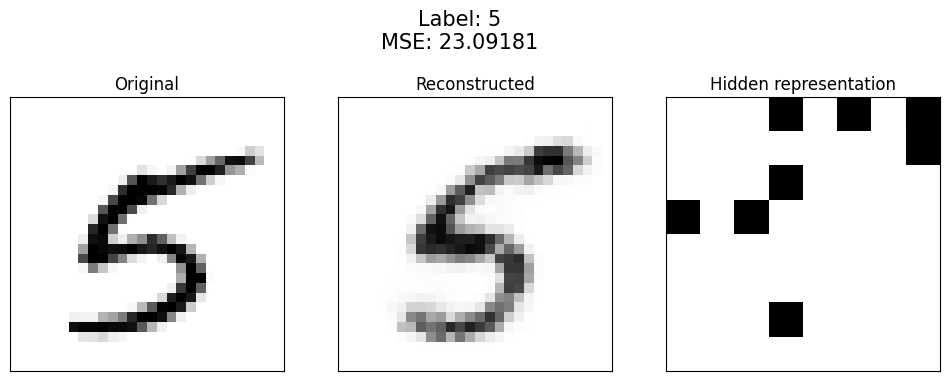





Digit 5 test MSE: 64.53959444711674


In [ ]:
digit = 5
plot_images(model, test_data, test_label, digit, k)
mse = compute_batch_mse(model, test_data[test_label == digit])
print(f"Digit {digit} test MSE: {mse}")

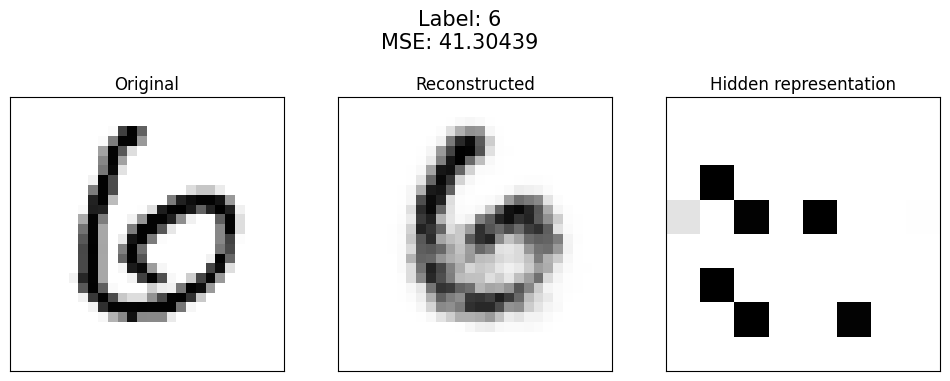

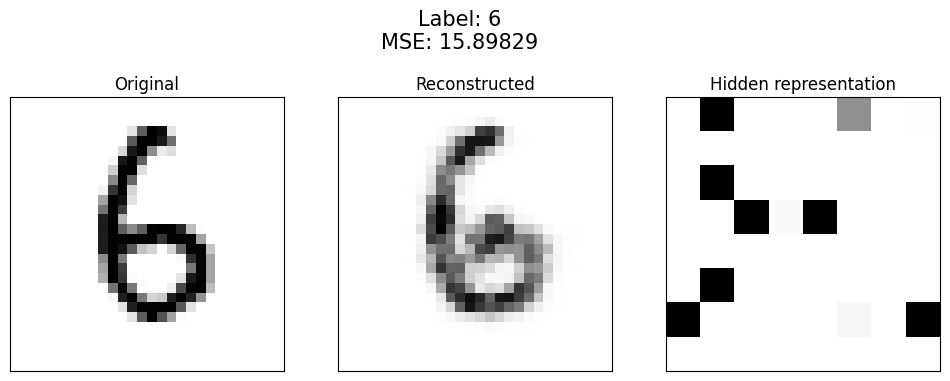

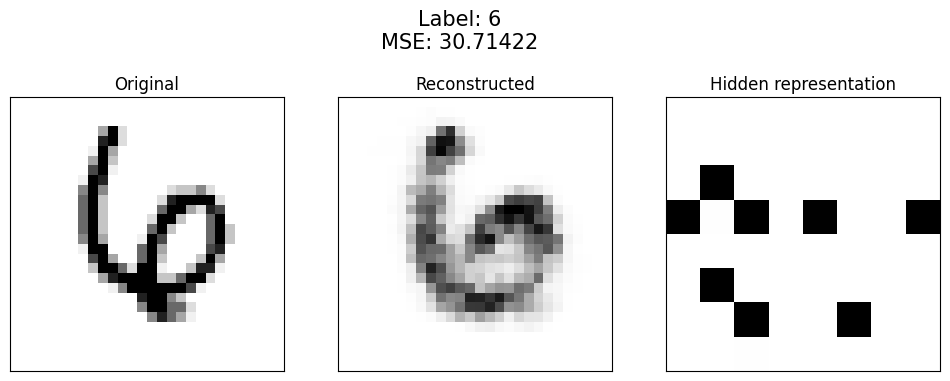

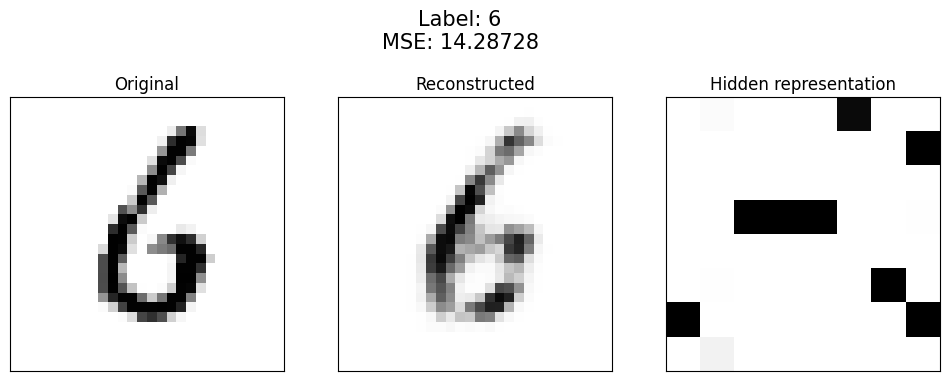

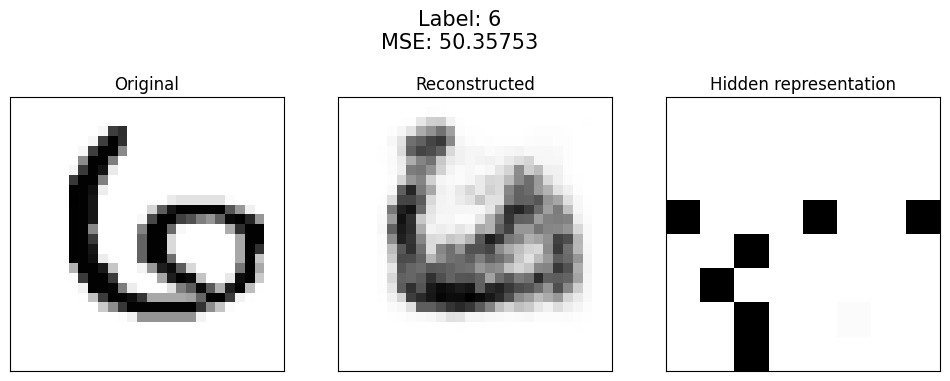





Digit 6 test MSE: 59.993210994005025


In [ ]:
digit = 6
plot_images(model, test_data, test_label, digit, k)
mse = compute_batch_mse(model, test_data[test_label == digit])
print(f"Digit {digit} test MSE: {mse}")

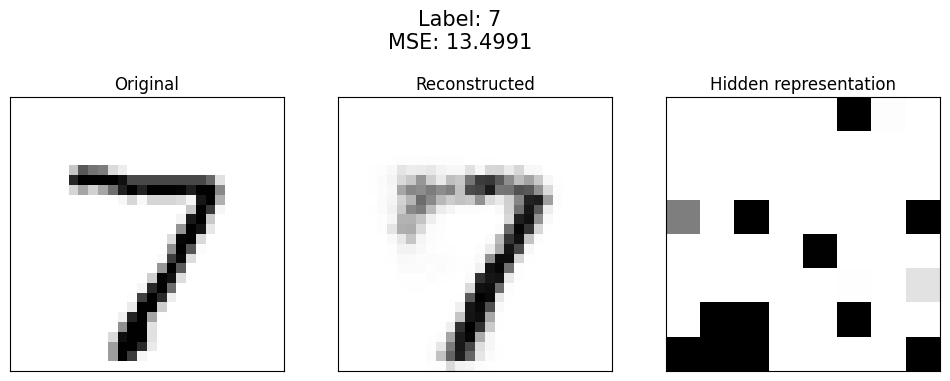

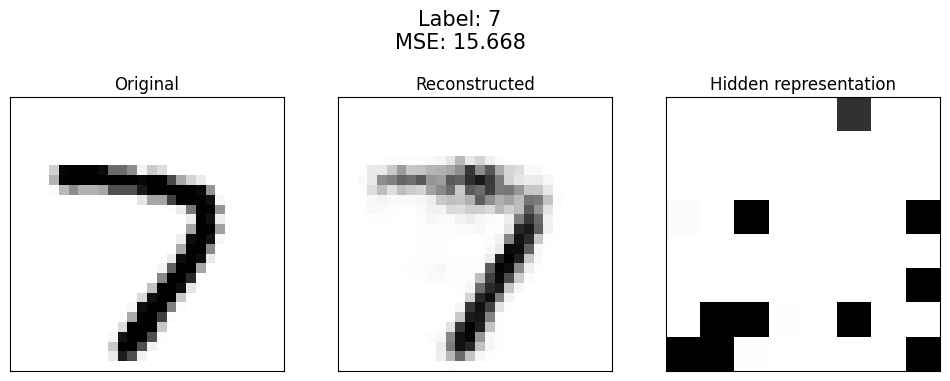

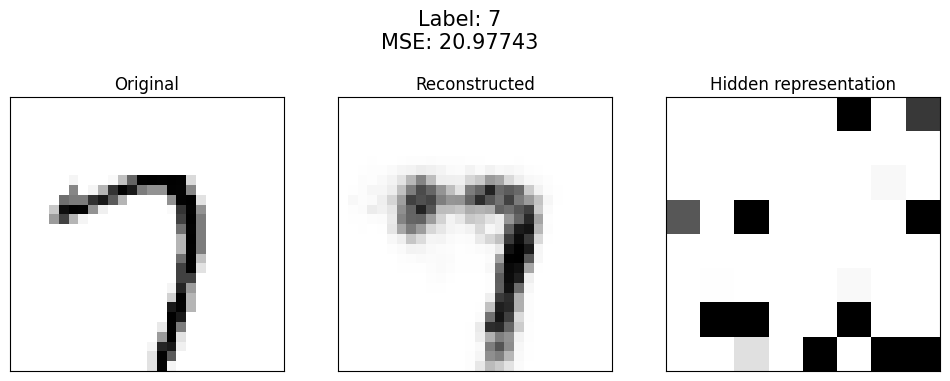

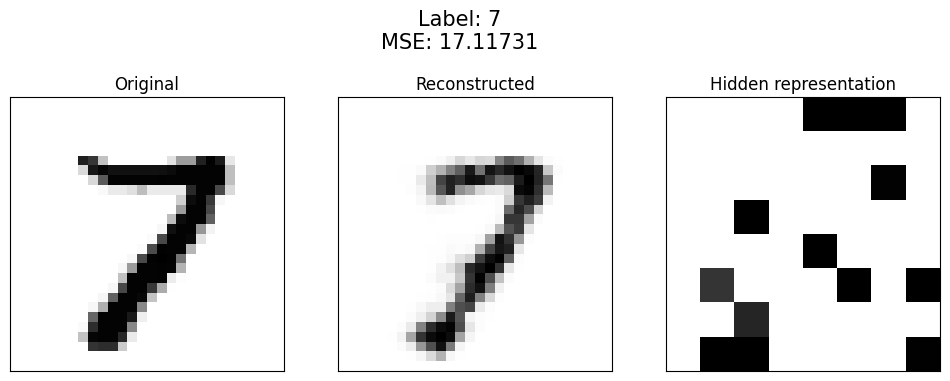

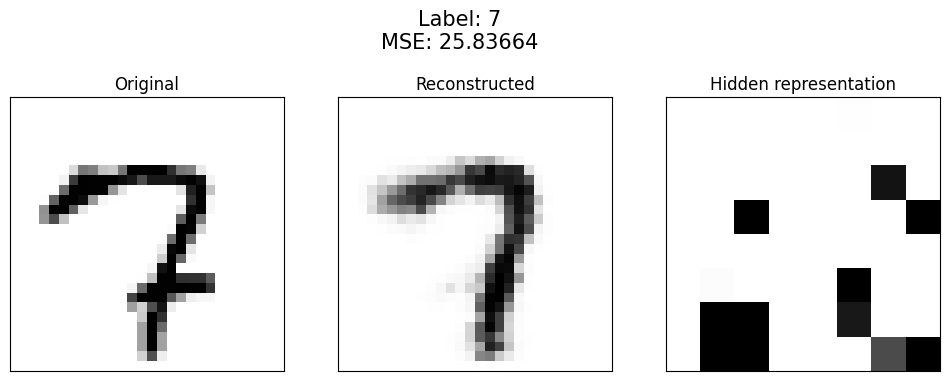





Digit 7 test MSE: 44.421438910805044


In [ ]:
digit = 7
plot_images(model, test_data, test_label, digit, k)
mse = compute_batch_mse(model, test_data[test_label == digit])
print(f"Digit {digit} test MSE: {mse}")

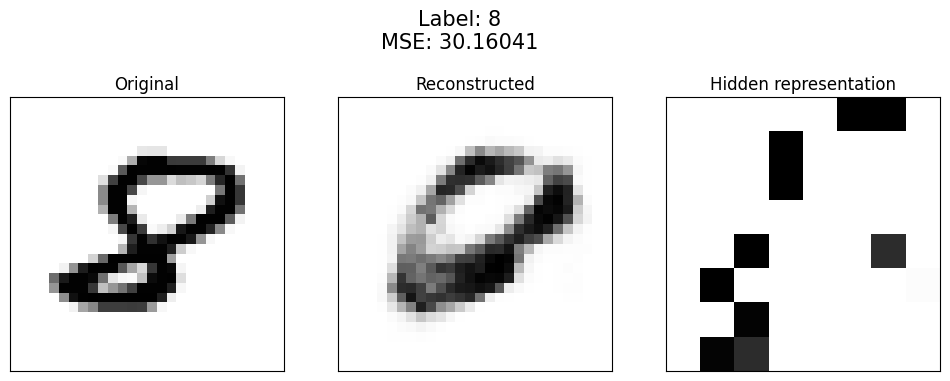

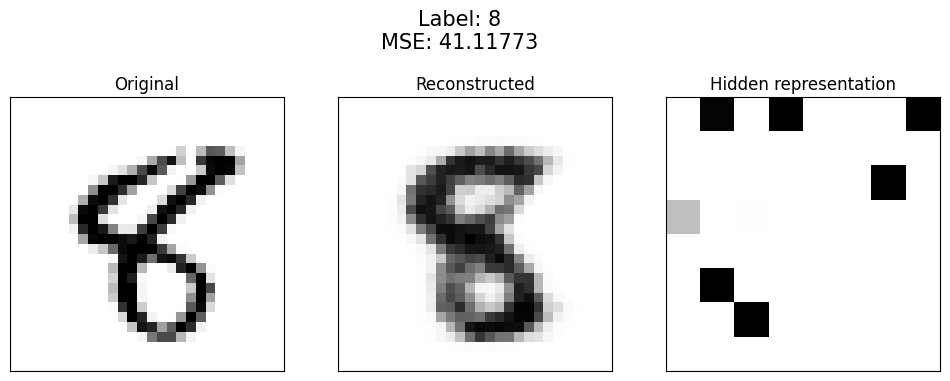

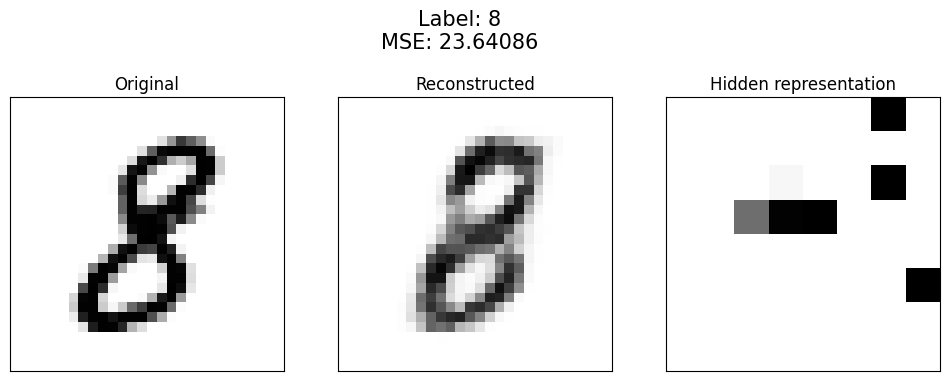

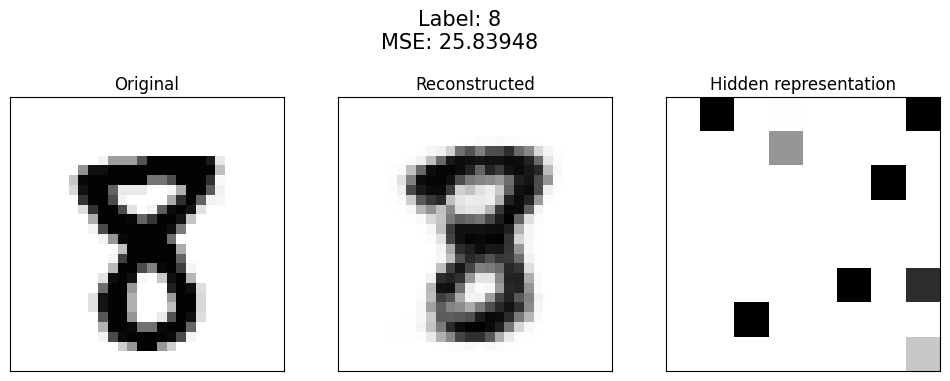

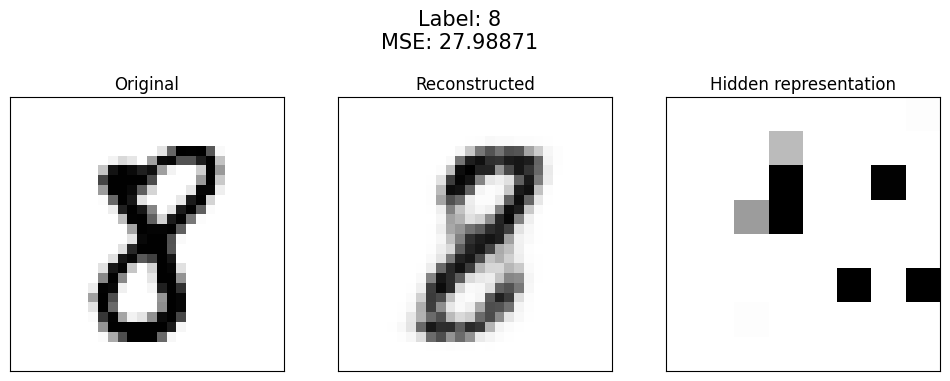





Digit 8 test MSE: 67.37445631004344


In [ ]:
digit = 8
plot_images(model, test_data, test_label, digit, k)
mse = compute_batch_mse(model, test_data[test_label == digit])
print(f"Digit {digit} test MSE: {mse}")

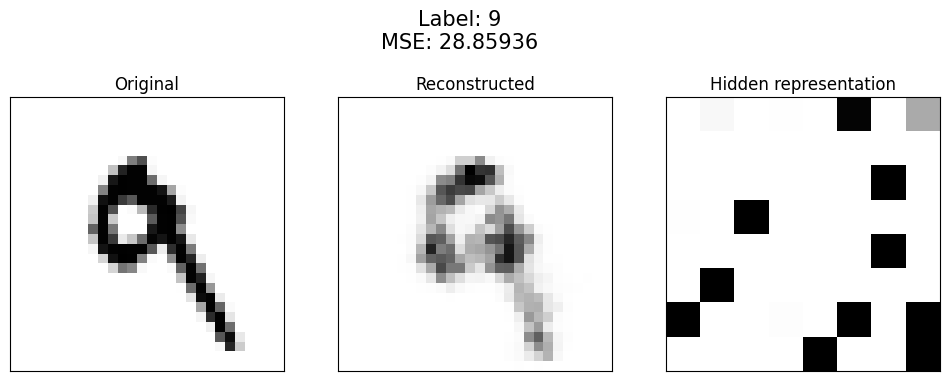

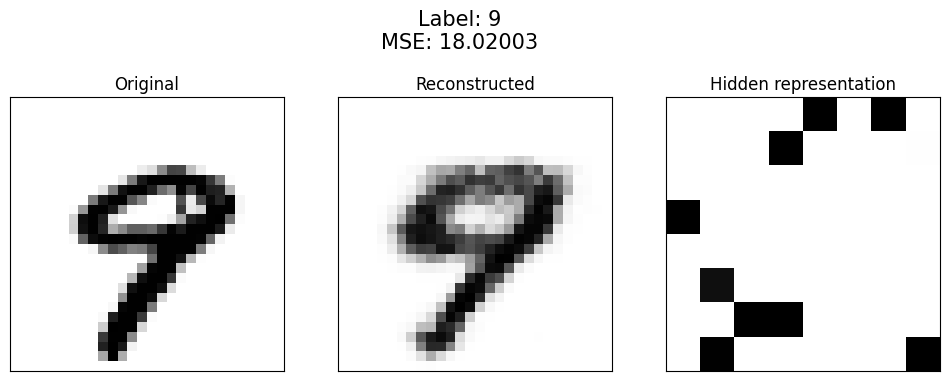

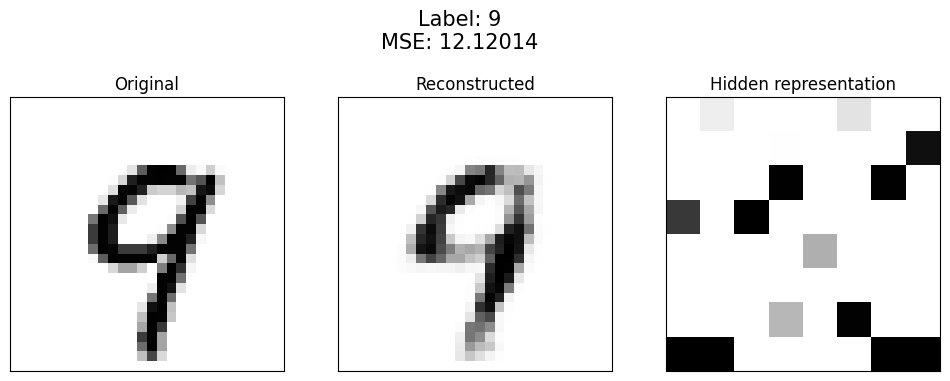

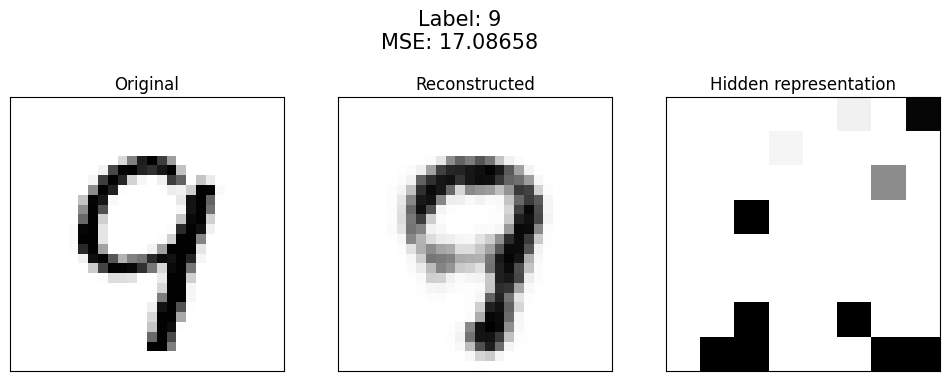

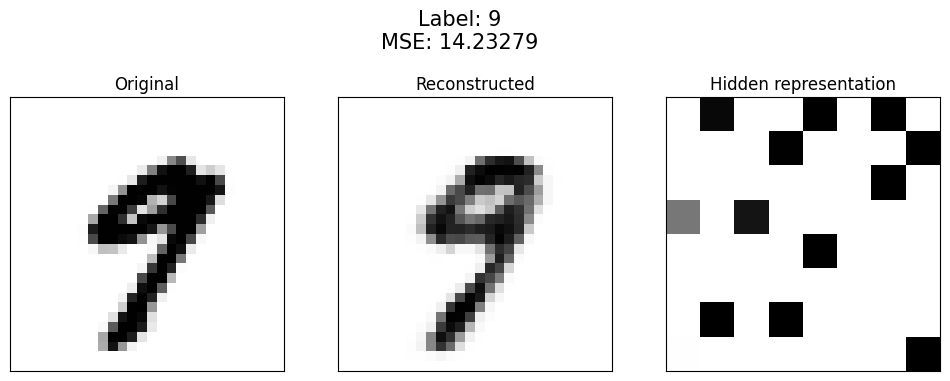





Digit 9 test MSE: 46.413321597357715


In [ ]:
digit = 9
plot_images(model, test_data, test_label, digit, k)
mse = compute_batch_mse(model, test_data[test_label == digit])
print(f"Digit {digit} test MSE: {mse}")

## Considerations

The RBM after the training is able to reconstruct the images quite well. Some digits are easier to reconstruct (for instance the 1) in fact they get a lower MSE as shown in the final examples. In the final examples is also possible to see that even though the images in general are well reconstructed, sometimes the model confuses one digit for another, for instance the reconstruction of one of the 4 is more similar to a 9 than a 4. There is also a 3 that is reconstructed as an 8, and an 8 that is reconstructed as a 0. This somehow makes sense since the digits which are sometimes mistakely swapped are similar digits.

It's interesting to notice that in the section of the notebook where the weights of the RBM are plotted as images, among the plots we can clearly recognize some of the digits.

In order to select the hyperparameters for the training of the model (the hidden dimension, the learning rate, the batch size and the number of epochs) I did some manual test, but a better model selection procedure could have been done. 